In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns

from tqdm import tqdm

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_cuda_device_or_cpu():
  if torch.cuda.is_available():
    cuda_count = torch.cuda.device_count()
    
    no = 0
    mem_available = 0

    for i in range(cuda_count):
      tmp_available = torch.cuda.mem_get_info(i)[0]
      if mem_available < tmp_available:
        no = i
        mem_available = tmp_available
    return f'cuda:{no}'
  return 'cpu'

device = get_cuda_device_or_cpu()
device

'cuda:0'

In [4]:
def get_model(dim_z: int, batch_size=128, less_than=10):

  # Download training data from open datasets.
  training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
  )

  training_data.data = training_data.data[training_data.targets < less_than]
  training_data.targets = training_data.targets[training_data.targets < less_than]

  # Create data loaders.
  dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

  encoder = nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, dim_z),
  )

  decoder = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 128),
    nn.Tanh(),
    nn.Linear(128, 512),
    nn.Tanh(),
    nn.Linear(512, 784),
    nn.Sigmoid(),
  )

  model = nn.Sequential(OrderedDict([
            ('encoder', encoder),
            ('decoder', decoder),
          ]))

  optimizer = torch.optim.Adam(model.parameters())

  return model, dataloader, optimizer

In [5]:
def train(model, dataloader, optimizer, run, epochs=5):
  
  model.to(device)
  model.train()

  hist = torch.zeros(0)

  for _ in tqdm(range(epochs)):
    tmp = run(model, dataloader, optimizer)
    hist = torch.cat([hist, tmp])
  
  return hist

In [6]:
def run_for_vae(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + kld

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

100%|██████████| 30/30 [03:13<00:00,  6.46s/it]


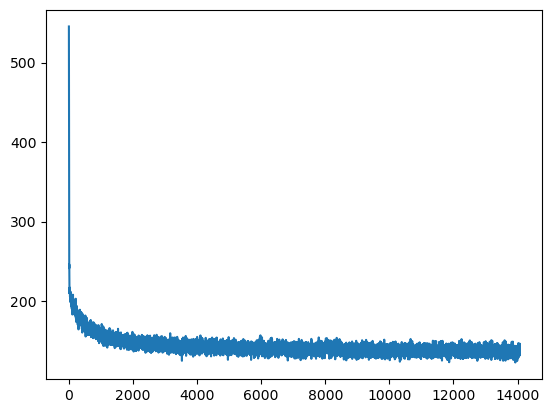

In [29]:
model, dataloader, optimizer = get_model(dim_z=4)
hist = train(model, dataloader, optimizer, run_for_vae, 30)
plt.plot(hist)
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

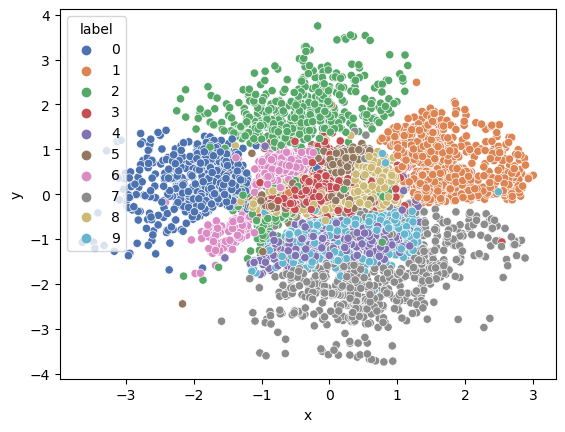

In [30]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

with torch.no_grad():
  idx = 0
  for x, y in dataloader:
    x = x.reshape([-1, 28*28])
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

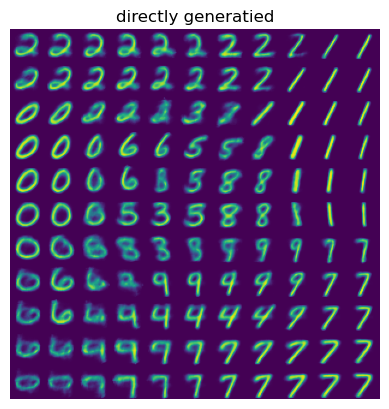

In [33]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('directly generatied')

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

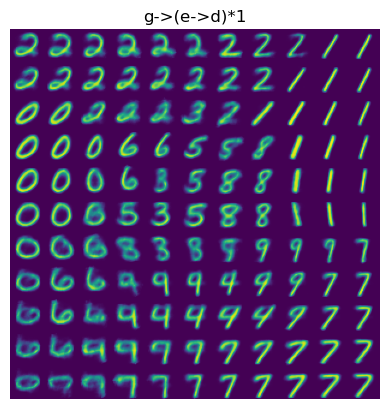

In [34]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    out_1 = decoder(r)
    h = model.get_submodule('encoder')(out_1)
    mu = h[:, :2]
    tmps = model.get_submodule('decoder')(mu).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*1')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

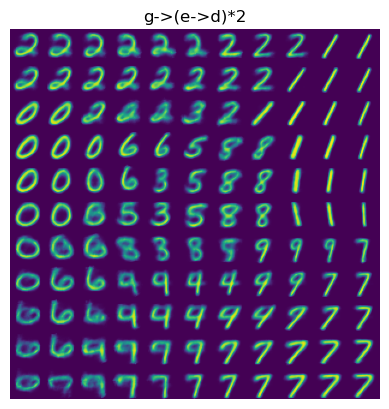

In [35]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    out_1 = decoder(r)
    h_1 = model.get_submodule('encoder')(out_1)
    mu_1 = h_1[:, :2]
    out_2 = model.get_submodule('decoder')(mu_1)
    h_2 = model.get_submodule('encoder')(out_2)
    mu_2 = h_2[:, :2]
    tmps = model.get_submodule('decoder')(mu_2).view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*2')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

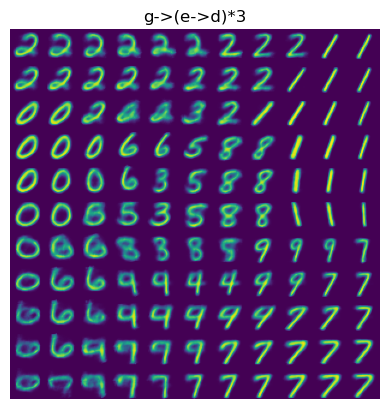

In [36]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    out_1 = decoder(r)
    h_1 = model.get_submodule('encoder')(out_1)
    mu_1 = h_1[:, :2]
    out_2 = model.get_submodule('decoder')(mu_1)
    h_2 = model.get_submodule('encoder')(out_2)
    mu_2 = h_2[:, :2]
    out_3 = model.get_submodule('decoder')(mu_2)
    h_3 = model.get_submodule('encoder')(out_3)
    mu_3 = h_3[:, :2]
    tmps = model.get_submodule('decoder')(mu_3).view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*3')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

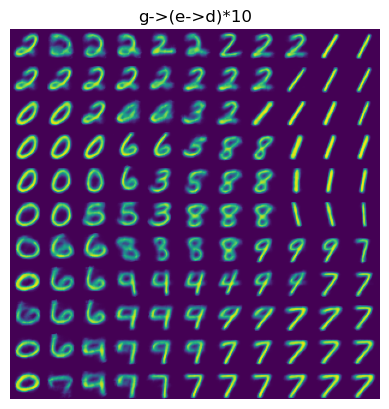

In [37]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    tmps = decoder(r)
    for _ in range(10):
      h = model.get_submodule('encoder')(tmps)
      mu = h[:, :2]
      tmps = model.get_submodule('decoder')(mu)
    tmps = tmps.view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*10')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

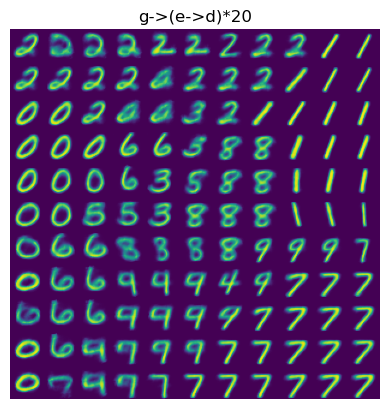

In [38]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    tmps = decoder(r)
    for _ in range(20):
      h = model.get_submodule('encoder')(tmps)
      mu = h[:, :2]
      tmps = model.get_submodule('decoder')(mu)
    tmps = tmps.view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*20')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

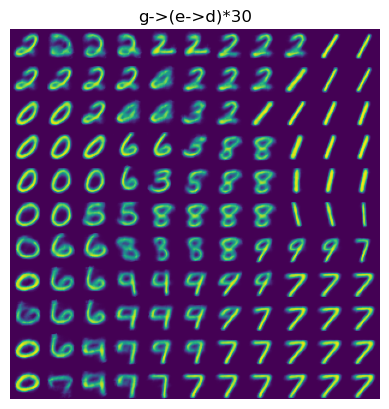

In [39]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    tmps = decoder(r)
    for _ in range(30):
      h = model.get_submodule('encoder')(tmps)
      mu = h[:, :2]
      tmps = model.get_submodule('decoder')(mu)
    tmps = tmps.view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*30')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

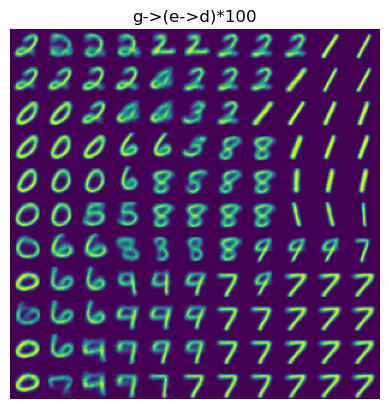

In [40]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    tmps = decoder(r)
    for _ in range(100):
      h = model.get_submodule('encoder')(tmps)
      mu = h[:, :2]
      tmps = model.get_submodule('decoder')(mu)
    tmps = tmps.view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*100')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

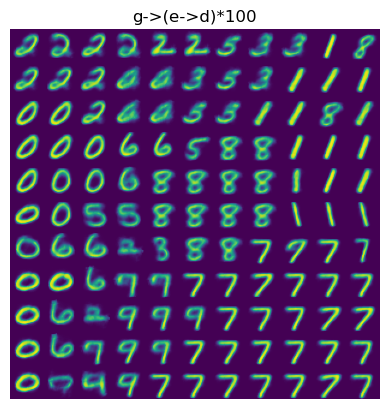

In [42]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # tmps = decoder(r).view([-1, 1, 28, 28])
    tmps = decoder(r)
    for _ in range(100):
      h = model.get_submodule('encoder')(tmps)
      mu = h[:, :2]
      sigma = F.softplus(h[:, 2:]) + 1e-6
      sampled_h = torch.randn([h.shape[0], 2]) * sigma + mu
      tmps = model.get_submodule('decoder')(sampled_h)
    tmps = tmps.view([-1, 1, 28, 28])

    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)
  plt.title('g->(e->d)*100')
  

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  